In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tpot import TPOTRegressor
import h2o
from h2o.automl import H2OAutoML
import pycaret
from pycaret.regression import RegressionExperiment
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv("Bengaluru_House_Data.csv",encoding='Latin-1')

In [3]:
# Extract categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Perform label encoding on categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Impute missing values with mean
df.fillna(df.mean(), inplace=True)

df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,3,40,419,13,464,70,2.0,1.0,10
1,2,80,317,19,2439,1288,5.0,3.0,1
2,0,80,1179,16,2688,514,2.0,3.0,16
3,3,80,757,16,2186,602,3.0,1.0,20
4,3,80,716,13,2688,239,2.0,1.0,13


In [5]:
columns_to_remove_outliers = ['size','total_sqft', "bath",'price']

# Convert columns to numeric if they contain string values
for col in columns_to_remove_outliers:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
# Define function to remove outliers using IQR method
def remove_outliers_iqr(df, col_list):
    for col in col_list:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Specify columns to remove outliers from
columns_to_remove_outliers = ['size', 'total_sqft', 'bath', 'price']

# Remove outliers from selected columns
df = remove_outliers_iqr(df, columns_to_remove_outliers)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11411 entries, 0 to 13318
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     11411 non-null  int32  
 1   availability  11411 non-null  int32  
 2   location      11411 non-null  int32  
 3   size          11411 non-null  int32  
 4   society       11411 non-null  int32  
 5   total_sqft    11411 non-null  int32  
 6   bath          11411 non-null  float64
 7   balcony       11411 non-null  float64
 8   price         11411 non-null  int32  
dtypes: float64(2), int32(7)
memory usage: 579.5 KB


# Pycaret

In [8]:
# check installed version (must be >3.0)
pycaret.__version__

'3.2.0'

In [15]:
from pycaret.regression import *
# Setup data and target variable
s=setup(df, target='price', session_id = 123)

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(11411, 9)"
4,Transformed data shape,"(11411, 9)"
5,Transformed train set shape,"(7987, 9)"
6,Transformed test set shape,"(3424, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [16]:
# model training and selection
best =compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,394.5190,276687.6870,525.8253,0.3179,0.7733,1.1130,1.2750
rf,Random Forest Regressor,374.7372,280705.3496,529.5854,0.3080,0.7567,1.0784,0.5970
lightgbm,Light Gradient Boosting Machine,398.9249,280953.8485,529.8878,0.3072,0.7749,1.1286,0.1100
xgboost,Extreme Gradient Boosting,382.9135,285765.2040,534.1710,0.2956,0.7851,1.1010,0.0690
gbr,Gradient Boosting Regressor,434.3981,302313.2643,549.7112,0.2545,0.8012,1.2030,0.1780
et,Extra Trees Regressor,387.2077,310829.2920,557.2391,0.2335,0.7819,1.0967,0.3400
ada,AdaBoost Regressor,490.6433,336917.7431,580.3573,0.1690,0.8441,1.3471,0.0310
knn,K Neighbors Regressor,420.8601,337466.5214,580.6503,0.1680,0.8110,1.1386,0.0180
lasso,Lasso Regression,518.1643,367447.8880,606.0742,0.0939,0.8652,1.3906,0.2610
llar,Lasso Least Angle Regression,518.1643,367447.8765,606.0742,0.0939,0.8652,1.3906,0.0140


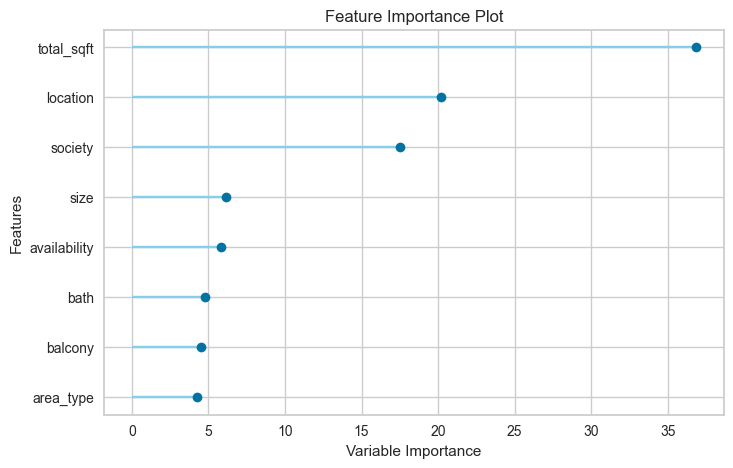

In [17]:
# plot feature importance
plot_model(best, plot = 'feature')

In [21]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# TPOT

In [22]:
# Separate features (X) and target variable (y)
X = df.drop(columns=["price"])  
y = df["price"]

# Initialize TPOT Regressor
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)

# Fit TPOT to find the best pipeline
tpot.fit(X, y)

# Export the optimized pipeline as a Python script
tpot.export('tpot_bengaluru_house_price_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -273861.12258999294

Generation 2 - Current best internal CV score: -272388.67614112946

Generation 3 - Current best internal CV score: -270268.17893828

Generation 4 - Current best internal CV score: -270268.17893828

Generation 5 - Current best internal CV score: -270268.17893828

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.55, min_samples_leaf=2, min_samples_split=9, n_estimators=100)


# h2o

In [23]:
# Initialize H2O cluster
h2o.init()

# Continue with your AutoML code
aml = H2OAutoML(max_models=10, seed=1)

# Ensure X and y correspond to the correct columns in your DataFrame df
X = df.drop('price', axis=1)
y = df['price']

# Combine X and y into a single DataFrame
df_combined = X.copy()
df_combined['price'] = y

# Convert X and y to H2OFrame
df_h2o = h2o.H2OFrame(df_combined)

# Train the AutoML model
aml.train(y='price', training_frame=df_h2o)

leaderboard = aml.leaderboard

# Get the best model from AutoML
best_model = aml.leader

# Save the best model
h2o.save_model(model=best_model, path='best_model', force=True)


# Print the leaderboard
print(leaderboard)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from C:\Users\mayan\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\mayan\AppData\Local\Temp\tmptlyeltdq
  JVM stdout: C:\Users\mayan\AppData\Local\Temp\tmptlyeltdq\h2o_mayan_started_from_python.out
  JVM stderr: C:\Users\mayan\AppData\Local\Temp\tmptlyeltdq\h2o_mayan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_mayan_cyf90q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.712 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:37:45.625: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse     mse      mae       rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20240213_213745     511.78   261919  376.879    0.755985                    261919
StackedEnsemble_BestOfFamily_1_AutoML_1_20240213_213745  511.986  262130  377.029    0.755811                    262130
GBM_grid_1_AutoML_1_20240213_213745_model_1              518.45   268791  386.963  nan                           268791
GBM_4_AutoML_1_20240213_213745                           520.371  270786  384.671  nan                           270786
XRT_1_AutoML_1_20240213_213745                           521.95   272432  385.012    0.761134                    272432
GBM_3_AutoML_1_20240213_213

In [27]:
saved_model = h2o.load_model(path='best_model\StackedEnsemble_AllModels_1_AutoML_1_20240213_213745')

In [28]:
# View details of the saved model
print(saved_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20240213_213745


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       6/10
# GBM base models (used / total)           4/6
# DRF base models (used / total)           2/2
# GLM base models (used / total)           0/1
# DeepLearning base models (used / total)  0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 127398.75262652506
RMSE: 356.9296185896108
MAE: 260.4809584992239
RMSLE: 0.6096124132946374
Mean Residual Deviance: 127398.75262652506
R^

The model consists of a combination of GBM (Gradient Boosting Machine)  and DRF (Distributed Random Forest) base models, with a GLM (Generalized Linear Model) metalearner for combining their predictions in a stacked ensemble approach.

In [29]:
print(saved_model.model_performance(test_data=df_h2o))

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 127713.88735763024
RMSE: 357.37079813217844
MAE: 260.70900613765644
RMSLE: 0.608507227456288
Mean Residual Deviance: 127713.88735763024
R^2: 0.6862792079607378
Null degrees of freedom: 11410
Residual degrees of freedom: 11404
Null deviance: 4645350915.904611
Residual deviance: 1457343168.6379187
AIC: 166564.39299052095
